# Model training.

[Dataset](https://www.kaggle.com/datasets/newslab/cholecseg8k?resource=download)


In [1]:
import os

os.environ["CUBLAS_WORKSPACE_CONFIG"]=":4096:8"

In [2]:
import torch
from glob import glob
import numpy as np
import time
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
import cv2
import random
from Uformer import modelIdentity
from losses import losses
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from torch.optim.lr_scheduler import CosineAnnealingLR

In [3]:
torch.cuda.is_available(), torch.cuda.get_device_name(0)

(True, 'NVIDIA GeForce RTX 2060 SUPER')

In [4]:
SEED = 33
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.use_deterministic_algorithms(True)

In [5]:
# determine the device to be used for training and evaluation
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
# determine if we will be pinning memory during data loading
PIN_MEMORY = True if DEVICE == "cuda" else False

NUM_CLASSES = 13
# initialize learning rate, number of epochs to train for, and the
# batch size
INIT_LR = 8e-5
WEIGHT_DECAY = 1e-8
NUM_EPOCHS = 100
BATCH_SIZE = 32
# define the input image dimensions
INPUT_IMAGE_WIDTH = 64
INPUT_IMAGE_HEIGHT = 64

## Data preparation.

In [6]:
IMAGE_DATASET_PATH = glob(f'../../Cholec8k/*/*/*/frame_*_endo.png')
MASK_DATASET_PATH  = glob(f'../../Cholec8k/*/*/*/frame_*_endo_watershed_mask.png')
N = len(IMAGE_DATASET_PATH)
assert len(IMAGE_DATASET_PATH) == len(MASK_DATASET_PATH)

print(f'Number of samples: {str(len(MASK_DATASET_PATH))}')

Number of samples: 8080


In [7]:
# https://gist.github.com/IdeaKing/11cf5e146d23c5bb219ba3508cca89ec
def resize_with_pad(image: np.array, 
                    new_shape, 
                    padding_color = (0, 0, 0)) -> np.array:
    """Maintains aspect ratio and resizes with padding.
    Params:
        image: Image to be resized.
        new_shape: Expected (width, height) of new image.
        padding_color: Tuple in BGR of padding color
    Returns:
        image: Resized image with padding
    """
    original_shape = (image.shape[1], image.shape[0])
    ratio = float(max(new_shape))/max(original_shape)
    new_size = tuple([int(x*ratio) for x in original_shape])
    image = cv2.resize(image, new_size, interpolation=cv2.INTER_NEAREST)
    delta_w = new_shape[0] - new_size[0]
    delta_h = new_shape[1] - new_size[1]
    top, bottom = delta_h//2, delta_h-(delta_h//2)
    left, right = delta_w//2, delta_w-(delta_w//2)
    image = cv2.copyMakeBorder(image, top, bottom, left, right, cv2.BORDER_CONSTANT, value=padding_color)
    return image

In [8]:
def to_categorical(y, num_classes=None, dtype="float32"):
	y = np.array(y, dtype="int")
	input_shape = y.shape

	# Shrink the last dimension if the shape is (..., 1).
	if input_shape and input_shape[-1] == 1 and len(input_shape) > 1:
		input_shape = tuple(input_shape[:-1])

	y = y.reshape(-1)
	if not num_classes:
		num_classes = np.max(y) + 1
	n = y.shape[0]
	categorical = np.zeros((n, num_classes), dtype=dtype)
	categorical[np.arange(n), y] = 1
	output_shape = input_shape + (num_classes,)
	categorical = np.reshape(categorical, output_shape)
	return categorical

labels = [[11],[21],[13],[12],[31],[23],[24],[25],[32],[22],[33],[5]]
def encode_mask(masks_arr, n_classes=NUM_CLASSES, H=INPUT_IMAGE_HEIGHT, W=INPUT_IMAGE_WIDTH, labels_arr=labels):
    y_encoded = np.zeros((H, W, 1), dtype=np.uint8)

    for i, label in enumerate(labels_arr):
        y_encoded[np.all(label == masks_arr, axis=-1)] = i + 1
    
    return to_categorical(y_encoded, num_classes=n_classes)

class SegmentationDataset(Dataset):
	def __init__(self, imagePaths, maskPaths):
		# store the image and mask filepaths, and augmentation
		# transforms
		self.imagePaths = imagePaths
		self.maskPaths = maskPaths

	def __len__(self):
		# return the number of total samples contained in the dataset
		return len(self.imagePaths)
	
	def __getitem__(self, idx):
		# grab the image path from the current index
		imagePath = self.imagePaths[idx]
		# load the image from disk, swap its channels from BGR to RGB,
		# and read the associated mask from disk in grayscale mode
		image = cv2.imread(imagePath)
		image = image[10:-10, 120:-120,:]
		image = resize_with_pad(image, (INPUT_IMAGE_WIDTH, INPUT_IMAGE_HEIGHT))
		image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
		image = image / 255
		image = torch.from_numpy(np.float32(image))
		image = image.permute(2,0,1)

		mask = cv2.imread(self.maskPaths[idx])
		mask = mask[10:-10, 120:-120,:]
		mask = resize_with_pad(mask, (INPUT_IMAGE_WIDTH, INPUT_IMAGE_HEIGHT), (50, 50, 50))
		mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
		mask = np.expand_dims(mask, axis=-1)
		mask = encode_mask(mask)
		mask = torch.from_numpy(np.float32(mask))
		mask = mask.permute(2,0,1)

		assert image.shape == (3, INPUT_IMAGE_HEIGHT, INPUT_IMAGE_WIDTH), f"Bad image shape {image.shape}"
		assert mask.shape == (13, INPUT_IMAGE_HEIGHT, INPUT_IMAGE_WIDTH), f"Bad mask shape {mask.shape}"

		# return a tuple of the image and its mask
		return image, mask

In [9]:
uformer = modelIdentity.Uformer(img_size=INPUT_IMAGE_HEIGHT,in_chans=13, embed_dim=16, win_size=8, token_projection='linear', token_mlp='leff',modulator=True)
trainImages, testImages, trainMasks, testMasks = train_test_split(IMAGE_DATASET_PATH, MASK_DATASET_PATH, test_size=0.2, random_state=43)

In [10]:
# define transformations
from torch.utils.data import DataLoader

# create the train and test datasets
trainDS = SegmentationDataset(imagePaths=trainImages, maskPaths=trainMasks)
testDS = SegmentationDataset(imagePaths=testImages, maskPaths=testMasks)
print(f"[INFO] found {len(trainDS)} examples in the training set...")
print(f"[INFO] found {len(testDS)} examples in the test set...")
# create the training and test data loaders
num_workers = 4
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(0)

trainLoader = DataLoader(
	trainDS, 
	shuffle=True,
	batch_size=BATCH_SIZE, 
	pin_memory=PIN_MEMORY,
    worker_init_fn=seed_worker,
    generator=g
)
testLoader = DataLoader(
	testDS, shuffle=False,
	batch_size=BATCH_SIZE, 
	pin_memory=PIN_MEMORY,
    worker_init_fn=seed_worker,
    generator=g
)

[INFO] found 6464 examples in the training set...
[INFO] found 1616 examples in the test set...


In [11]:
uformer = uformer.to(DEVICE)
softmax = torch.nn.Softmax(1)
# initialize loss function and optimizer
lossFunc = losses.TverskyLoss().cuda()
opt = torch.optim.Adam(uformer.parameters(), lr=INIT_LR, betas=(0.9, 0.999),eps=1e-8, weight_decay=WEIGHT_DECAY)
iouMetric = losses.MeanIoU().cuda()
gdlMetric = losses.DiceCoeficient().cuda()

# calculate steps per epoch for training and test set
trainSteps = len(trainDS) // BATCH_SIZE + 1
testSteps = len(testDS) // BATCH_SIZE + 1

scheduler = CosineAnnealingLR(opt, T_max=trainSteps*NUM_EPOCHS)

# initialize a dictionary to store training history
H = {"train_loss": [], "test_loss": [], "train_IoU": [], "test_IoU": [],"train_DC": [], "test_DC": []}

In [12]:
bestIoU = 0
# loop over epochs
print("[INFO] training the network...")
startTime = time.time()
for e in range(NUM_EPOCHS):
	# torch.cuda.empty_cache()
	# set the model in training mode
	uformer.train()
	# initialize the total training and validation loss
	totalTrainLoss = 0
	totalTestLoss = 0

	totalTrainIoU = 0
	totalTestIoU = 0
	totalTrainDC = 0
	totalTestDC = 0
	# loop over the training set
	for i, (x, y) in enumerate(tqdm(trainLoader)):
		# send the input to the device
		x, y = x.to(DEVICE), y.to(DEVICE)
		# perform a forward pass and calculate the training loss
		pred = uformer(x)
		assert pred.shape == y.shape, f"{pred.shape} != {y.shape}" # B, C, H, W
		pred = softmax(pred)
		loss = lossFunc(pred, y)
		# first, zero out any previously accumulated gradients, then
		# perform backpropagation, and then update model parameters
		opt.zero_grad()
		loss.backward()
		opt.step()
		scheduler.step()
		# add the loss to the total training loss so far
		totalTrainLoss += loss
		totalTrainIoU += iouMetric(pred, y)
		totalTrainDC += gdlMetric(pred, y)
	# switch off autograd
	with torch.no_grad():
		# set the model in evaluation mode
		uformer.eval()
		# loop over the validation set
		for (x, y) in testLoader:
			# send the input to the device
			(x, y) = (x.to(DEVICE), y.to(DEVICE))
			# make the predictions and calculate the validation loss
			pred = uformer(x)
			assert pred.shape == y.shape, f"{pred.shape} != {y.shape}" # B, C, H, W
			pred = softmax(pred)
			totalTestLoss += lossFunc(pred, y)
			totalTestIoU += iouMetric(pred, y)
			totalTestDC += gdlMetric(pred, y)
			
	# calculate the average training and validation loss
	avgTrainLoss = totalTrainLoss / trainSteps
	avgTestLoss = totalTestLoss / testSteps

	avgTrainIoU = totalTrainIoU / trainSteps
	avgTestIoU = totalTestIoU / testSteps
	avgTrainDC = totalTrainDC / trainSteps
	avgTestDC = totalTestDC / testSteps
	# update our training history
	H["train_loss"].append(avgTrainLoss.cpu().detach().numpy())
	H["test_loss"].append(avgTestLoss.cpu().detach().numpy())

	H["train_IoU"].append(avgTrainIoU.cpu().detach().numpy())
	H["test_IoU"].append(avgTestIoU.cpu().detach().numpy())
	H["train_DC"].append(avgTrainDC.cpu().detach().numpy())
	H["test_DC"].append(avgTestDC.cpu().detach().numpy())

	# print the model training and validation information
	print("[INFO] EPOCH: {}/{}".format(e + 1, NUM_EPOCHS))
	print(f"Train loss: {avgTrainLoss:.6f}, Test loss: {avgTestLoss:.4f}, " + 
       f"Train IoU: {avgTrainIoU:.4f}, Test IoU: {avgTestIoU:.4f}, Train Dice: {avgTrainDC:.4f}, Test Dice: {avgTestDC:.4f}")
	
	if avgTestIoU > bestIoU:
		bestIoU = avgTestIoU
		torch.save(uformer.state_dict(), '../models/uformeridentity_tversky.pth')
		print('Best IoU improved. Model saved.')
		
# display the total time needed to perform the training
endTime = time.time()
print("[INFO] total time taken to train the model: {:.2f}s".format(endTime - startTime))
print(f'Best IoU is: {bestIoU:.5f}')

[INFO] training the network...


100%|██████████| 202/202 [01:41<00:00,  1.98it/s]


[INFO] EPOCH: 1/100
Train loss: 0.600227, Test loss: 0.4482, Train IoU: 0.2551, Test IoU: 0.3817, Train Dice: 0.3948, Test Dice: 0.5518
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:58<00:00,  1.70it/s]


[INFO] EPOCH: 2/100
Train loss: 0.402497, Test loss: 0.3591, Train IoU: 0.4229, Test IoU: 0.4723, Train Dice: 0.5926, Test Dice: 0.6409
Best IoU improved. Model saved.


100%|██████████| 202/202 [02:04<00:00,  1.62it/s]


[INFO] EPOCH: 3/100
Train loss: 0.316060, Test loss: 0.2880, Train IoU: 0.5161, Test IoU: 0.5534, Train Dice: 0.6790, Test Dice: 0.7120
Best IoU improved. Model saved.


100%|██████████| 202/202 [02:06<00:00,  1.60it/s]


[INFO] EPOCH: 4/100
Train loss: 0.257210, Test loss: 0.2194, Train IoU: 0.5870, Test IoU: 0.6406, Train Dice: 0.7379, Test Dice: 0.7806
Best IoU improved. Model saved.


100%|██████████| 202/202 [02:04<00:00,  1.63it/s]


[INFO] EPOCH: 5/100
Train loss: 0.194651, Test loss: 0.1793, Train IoU: 0.6699, Test IoU: 0.6963, Train Dice: 0.8004, Test Dice: 0.8207
Best IoU improved. Model saved.


100%|██████████| 202/202 [02:02<00:00,  1.66it/s]


[INFO] EPOCH: 6/100
Train loss: 0.169165, Test loss: 0.1674, Train IoU: 0.7062, Test IoU: 0.7136, Train Dice: 0.8259, Test Dice: 0.8326
Best IoU improved. Model saved.


100%|██████████| 202/202 [02:04<00:00,  1.62it/s]


[INFO] EPOCH: 7/100
Train loss: 0.159176, Test loss: 0.1553, Train IoU: 0.7209, Test IoU: 0.7315, Train Dice: 0.8359, Test Dice: 0.8447
Best IoU improved. Model saved.


100%|██████████| 202/202 [02:04<00:00,  1.62it/s]


[INFO] EPOCH: 8/100
Train loss: 0.151019, Test loss: 0.1510, Train IoU: 0.7332, Test IoU: 0.7379, Train Dice: 0.8441, Test Dice: 0.8490
Best IoU improved. Model saved.


100%|██████████| 202/202 [02:04<00:00,  1.62it/s]


[INFO] EPOCH: 9/100
Train loss: 0.145981, Test loss: 0.1458, Train IoU: 0.7408, Test IoU: 0.7458, Train Dice: 0.8491, Test Dice: 0.8542
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:59<00:00,  1.69it/s]


[INFO] EPOCH: 10/100
Train loss: 0.142122, Test loss: 0.1420, Train IoU: 0.7467, Test IoU: 0.7517, Train Dice: 0.8530, Test Dice: 0.8580
Best IoU improved. Model saved.


100%|██████████| 202/202 [02:04<00:00,  1.62it/s]


[INFO] EPOCH: 11/100
Train loss: 0.138187, Test loss: 0.1389, Train IoU: 0.7527, Test IoU: 0.7564, Train Dice: 0.8569, Test Dice: 0.8611
Best IoU improved. Model saved.


100%|██████████| 202/202 [02:02<00:00,  1.65it/s]


[INFO] EPOCH: 12/100
Train loss: 0.133831, Test loss: 0.1311, Train IoU: 0.7594, Test IoU: 0.7686, Train Dice: 0.8612, Test Dice: 0.8689
Best IoU improved. Model saved.


100%|██████████| 202/202 [02:06<00:00,  1.60it/s]


[INFO] EPOCH: 13/100
Train loss: 0.129573, Test loss: 0.1323, Train IoU: 0.7660, Test IoU: 0.7667, Train Dice: 0.8655, Test Dice: 0.8677


100%|██████████| 202/202 [02:02<00:00,  1.65it/s]


[INFO] EPOCH: 14/100
Train loss: 0.126692, Test loss: 0.1245, Train IoU: 0.7706, Test IoU: 0.7790, Train Dice: 0.8684, Test Dice: 0.8755
Best IoU improved. Model saved.


100%|██████████| 202/202 [02:04<00:00,  1.62it/s]


[INFO] EPOCH: 15/100
Train loss: 0.123982, Test loss: 0.1259, Train IoU: 0.7748, Test IoU: 0.7767, Train Dice: 0.8711, Test Dice: 0.8741


100%|██████████| 202/202 [02:01<00:00,  1.66it/s]


[INFO] EPOCH: 16/100
Train loss: 0.122821, Test loss: 0.1221, Train IoU: 0.7767, Test IoU: 0.7828, Train Dice: 0.8723, Test Dice: 0.8779
Best IoU improved. Model saved.


100%|██████████| 202/202 [02:07<00:00,  1.59it/s]


[INFO] EPOCH: 17/100
Train loss: 0.119908, Test loss: 0.1207, Train IoU: 0.7813, Test IoU: 0.7849, Train Dice: 0.8752, Test Dice: 0.8793
Best IoU improved. Model saved.


100%|██████████| 202/202 [02:00<00:00,  1.68it/s]


[INFO] EPOCH: 18/100
Train loss: 0.117852, Test loss: 0.1180, Train IoU: 0.7847, Test IoU: 0.7893, Train Dice: 0.8772, Test Dice: 0.8820
Best IoU improved. Model saved.


100%|██████████| 202/202 [02:04<00:00,  1.62it/s]


[INFO] EPOCH: 19/100
Train loss: 0.117078, Test loss: 0.1188, Train IoU: 0.7858, Test IoU: 0.7879, Train Dice: 0.8780, Test Dice: 0.8812


100%|██████████| 202/202 [02:00<00:00,  1.68it/s]


[INFO] EPOCH: 20/100
Train loss: 0.115540, Test loss: 0.1154, Train IoU: 0.7883, Test IoU: 0.7934, Train Dice: 0.8795, Test Dice: 0.8846
Best IoU improved. Model saved.


100%|██████████| 202/202 [02:05<00:00,  1.61it/s]


[INFO] EPOCH: 21/100
Train loss: 0.114048, Test loss: 0.1148, Train IoU: 0.7907, Test IoU: 0.7944, Train Dice: 0.8810, Test Dice: 0.8852
Best IoU improved. Model saved.


100%|██████████| 202/202 [02:00<00:00,  1.67it/s]


[INFO] EPOCH: 22/100
Train loss: 0.113700, Test loss: 0.1133, Train IoU: 0.7913, Test IoU: 0.7968, Train Dice: 0.8814, Test Dice: 0.8867
Best IoU improved. Model saved.


100%|██████████| 202/202 [02:05<00:00,  1.61it/s]


[INFO] EPOCH: 23/100
Train loss: 0.112449, Test loss: 0.1135, Train IoU: 0.7933, Test IoU: 0.7965, Train Dice: 0.8826, Test Dice: 0.8865


100%|██████████| 202/202 [02:00<00:00,  1.68it/s]


[INFO] EPOCH: 24/100
Train loss: 0.110863, Test loss: 0.1149, Train IoU: 0.7959, Test IoU: 0.7943, Train Dice: 0.8842, Test Dice: 0.8851


100%|██████████| 202/202 [02:05<00:00,  1.61it/s]


[INFO] EPOCH: 25/100
Train loss: 0.110898, Test loss: 0.1110, Train IoU: 0.7958, Test IoU: 0.8005, Train Dice: 0.8842, Test Dice: 0.8890
Best IoU improved. Model saved.


100%|██████████| 202/202 [02:01<00:00,  1.67it/s]


[INFO] EPOCH: 26/100
Train loss: 0.109193, Test loss: 0.1098, Train IoU: 0.7985, Test IoU: 0.8025, Train Dice: 0.8859, Test Dice: 0.8902
Best IoU improved. Model saved.


100%|██████████| 202/202 [02:06<00:00,  1.60it/s]


[INFO] EPOCH: 27/100
Train loss: 0.108282, Test loss: 0.1089, Train IoU: 0.8001, Test IoU: 0.8039, Train Dice: 0.8868, Test Dice: 0.8911
Best IoU improved. Model saved.


100%|██████████| 202/202 [02:00<00:00,  1.68it/s]


[INFO] EPOCH: 28/100
Train loss: 0.108213, Test loss: 0.1096, Train IoU: 0.8001, Test IoU: 0.8028, Train Dice: 0.8869, Test Dice: 0.8904


100%|██████████| 202/202 [02:04<00:00,  1.62it/s]


[INFO] EPOCH: 29/100
Train loss: 0.106447, Test loss: 0.1078, Train IoU: 0.8030, Test IoU: 0.8057, Train Dice: 0.8886, Test Dice: 0.8922
Best IoU improved. Model saved.


100%|██████████| 202/202 [02:00<00:00,  1.68it/s]


[INFO] EPOCH: 30/100
Train loss: 0.105524, Test loss: 0.1051, Train IoU: 0.8045, Test IoU: 0.8102, Train Dice: 0.8895, Test Dice: 0.8949
Best IoU improved. Model saved.


100%|██████████| 202/202 [02:04<00:00,  1.62it/s]


[INFO] EPOCH: 31/100
Train loss: 0.103406, Test loss: 0.1027, Train IoU: 0.8079, Test IoU: 0.8140, Train Dice: 0.8917, Test Dice: 0.8973
Best IoU improved. Model saved.


100%|██████████| 202/202 [02:01<00:00,  1.66it/s]


[INFO] EPOCH: 32/100
Train loss: 0.099958, Test loss: 0.0969, Train IoU: 0.8136, Test IoU: 0.8235, Train Dice: 0.8951, Test Dice: 0.9031
Best IoU improved. Model saved.


100%|██████████| 202/202 [02:06<00:00,  1.59it/s]


[INFO] EPOCH: 33/100
Train loss: 0.095794, Test loss: 0.0952, Train IoU: 0.8204, Test IoU: 0.8264, Train Dice: 0.8993, Test Dice: 0.9048
Best IoU improved. Model saved.


100%|██████████| 202/202 [02:00<00:00,  1.68it/s]


[INFO] EPOCH: 34/100
Train loss: 0.094077, Test loss: 0.0942, Train IoU: 0.8233, Test IoU: 0.8280, Train Dice: 0.9010, Test Dice: 0.9058
Best IoU improved. Model saved.


100%|██████████| 202/202 [02:04<00:00,  1.62it/s]


[INFO] EPOCH: 35/100
Train loss: 0.092355, Test loss: 0.0925, Train IoU: 0.8262, Test IoU: 0.8308, Train Dice: 0.9027, Test Dice: 0.9075
Best IoU improved. Model saved.


100%|██████████| 202/202 [02:00<00:00,  1.68it/s]


[INFO] EPOCH: 36/100
Train loss: 0.091347, Test loss: 0.0918, Train IoU: 0.8279, Test IoU: 0.8321, Train Dice: 0.9037, Test Dice: 0.9082
Best IoU improved. Model saved.


100%|██████████| 202/202 [02:04<00:00,  1.62it/s]


[INFO] EPOCH: 37/100
Train loss: 0.090061, Test loss: 0.0894, Train IoU: 0.8300, Test IoU: 0.8361, Train Dice: 0.9050, Test Dice: 0.9106
Best IoU improved. Model saved.


100%|██████████| 202/202 [02:00<00:00,  1.68it/s]


[INFO] EPOCH: 38/100
Train loss: 0.089216, Test loss: 0.0889, Train IoU: 0.8314, Test IoU: 0.8369, Train Dice: 0.9059, Test Dice: 0.9111
Best IoU improved. Model saved.


100%|██████████| 202/202 [02:04<00:00,  1.62it/s]


[INFO] EPOCH: 39/100
Train loss: 0.088200, Test loss: 0.0889, Train IoU: 0.8332, Test IoU: 0.8369, Train Dice: 0.9069, Test Dice: 0.9111
Best IoU improved. Model saved.


100%|██████████| 202/202 [02:00<00:00,  1.68it/s]


[INFO] EPOCH: 40/100
Train loss: 0.086734, Test loss: 0.0878, Train IoU: 0.8356, Test IoU: 0.8387, Train Dice: 0.9083, Test Dice: 0.9122
Best IoU improved. Model saved.


100%|██████████| 202/202 [02:05<00:00,  1.62it/s]


[INFO] EPOCH: 41/100
Train loss: 0.085872, Test loss: 0.0856, Train IoU: 0.8371, Test IoU: 0.8425, Train Dice: 0.9092, Test Dice: 0.9144
Best IoU improved. Model saved.


100%|██████████| 202/202 [02:01<00:00,  1.66it/s]


[INFO] EPOCH: 42/100
Train loss: 0.085209, Test loss: 0.0851, Train IoU: 0.8382, Test IoU: 0.8432, Train Dice: 0.9099, Test Dice: 0.9149
Best IoU improved. Model saved.


100%|██████████| 202/202 [02:06<00:00,  1.59it/s]


[INFO] EPOCH: 43/100
Train loss: 0.084985, Test loss: 0.0847, Train IoU: 0.8386, Test IoU: 0.8439, Train Dice: 0.9101, Test Dice: 0.9153
Best IoU improved. Model saved.


100%|██████████| 202/202 [02:00<00:00,  1.68it/s]


[INFO] EPOCH: 44/100
Train loss: 0.083694, Test loss: 0.0837, Train IoU: 0.8408, Test IoU: 0.8456, Train Dice: 0.9114, Test Dice: 0.9163
Best IoU improved. Model saved.


100%|██████████| 202/202 [02:04<00:00,  1.62it/s]


[INFO] EPOCH: 45/100
Train loss: 0.083537, Test loss: 0.0829, Train IoU: 0.8410, Test IoU: 0.8471, Train Dice: 0.9115, Test Dice: 0.9171
Best IoU improved. Model saved.


100%|██████████| 202/202 [02:01<00:00,  1.66it/s]


[INFO] EPOCH: 46/100
Train loss: 0.082882, Test loss: 0.0827, Train IoU: 0.8422, Test IoU: 0.8474, Train Dice: 0.9122, Test Dice: 0.9173
Best IoU improved. Model saved.


100%|██████████| 202/202 [02:04<00:00,  1.62it/s]


[INFO] EPOCH: 47/100
Train loss: 0.082479, Test loss: 0.0827, Train IoU: 0.8429, Test IoU: 0.8474, Train Dice: 0.9126, Test Dice: 0.9173


100%|██████████| 202/202 [02:00<00:00,  1.68it/s]


[INFO] EPOCH: 48/100
Train loss: 0.081770, Test loss: 0.0821, Train IoU: 0.8441, Test IoU: 0.8485, Train Dice: 0.9133, Test Dice: 0.9179
Best IoU improved. Model saved.


100%|██████████| 202/202 [02:05<00:00,  1.62it/s]


[INFO] EPOCH: 49/100
Train loss: 0.081423, Test loss: 0.0831, Train IoU: 0.8446, Test IoU: 0.8468, Train Dice: 0.9137, Test Dice: 0.9169


100%|██████████| 202/202 [02:00<00:00,  1.68it/s]


[INFO] EPOCH: 50/100
Train loss: 0.080875, Test loss: 0.0812, Train IoU: 0.8456, Test IoU: 0.8500, Train Dice: 0.9142, Test Dice: 0.9188
Best IoU improved. Model saved.


100%|██████████| 202/202 [02:04<00:00,  1.62it/s]


[INFO] EPOCH: 51/100
Train loss: 0.080394, Test loss: 0.0815, Train IoU: 0.8464, Test IoU: 0.8495, Train Dice: 0.9147, Test Dice: 0.9185


100%|██████████| 202/202 [02:00<00:00,  1.68it/s]


[INFO] EPOCH: 52/100
Train loss: 0.080061, Test loss: 0.0805, Train IoU: 0.8470, Test IoU: 0.8511, Train Dice: 0.9150, Test Dice: 0.9195
Best IoU improved. Model saved.


100%|██████████| 202/202 [02:04<00:00,  1.62it/s]


[INFO] EPOCH: 53/100
Train loss: 0.079643, Test loss: 0.0797, Train IoU: 0.8477, Test IoU: 0.8526, Train Dice: 0.9154, Test Dice: 0.9203
Best IoU improved. Model saved.


100%|██████████| 202/202 [02:00<00:00,  1.68it/s]


[INFO] EPOCH: 54/100
Train loss: 0.079220, Test loss: 0.0799, Train IoU: 0.8484, Test IoU: 0.8522, Train Dice: 0.9159, Test Dice: 0.9201


100%|██████████| 202/202 [02:04<00:00,  1.62it/s]


[INFO] EPOCH: 55/100
Train loss: 0.078632, Test loss: 0.0790, Train IoU: 0.8494, Test IoU: 0.8537, Train Dice: 0.9164, Test Dice: 0.9210
Best IoU improved. Model saved.


100%|██████████| 202/202 [02:00<00:00,  1.68it/s]


[INFO] EPOCH: 56/100
Train loss: 0.078287, Test loss: 0.0786, Train IoU: 0.8500, Test IoU: 0.8543, Train Dice: 0.9168, Test Dice: 0.9214
Best IoU improved. Model saved.


100%|██████████| 202/202 [02:04<00:00,  1.62it/s]


[INFO] EPOCH: 57/100
Train loss: 0.077931, Test loss: 0.0786, Train IoU: 0.8506, Test IoU: 0.8544, Train Dice: 0.9171, Test Dice: 0.9214
Best IoU improved. Model saved.


100%|██████████| 202/202 [02:00<00:00,  1.68it/s]


[INFO] EPOCH: 58/100
Train loss: 0.077736, Test loss: 0.0782, Train IoU: 0.8510, Test IoU: 0.8551, Train Dice: 0.9173, Test Dice: 0.9218
Best IoU improved. Model saved.


100%|██████████| 202/202 [02:05<00:00,  1.61it/s]


[INFO] EPOCH: 59/100
Train loss: 0.077238, Test loss: 0.0778, Train IoU: 0.8518, Test IoU: 0.8557, Train Dice: 0.9178, Test Dice: 0.9222
Best IoU improved. Model saved.


100%|██████████| 202/202 [02:00<00:00,  1.67it/s]


[INFO] EPOCH: 60/100
Train loss: 0.077199, Test loss: 0.0774, Train IoU: 0.8519, Test IoU: 0.8565, Train Dice: 0.9179, Test Dice: 0.9226
Best IoU improved. Model saved.


100%|██████████| 202/202 [02:06<00:00,  1.59it/s]


[INFO] EPOCH: 61/100
Train loss: 0.076632, Test loss: 0.0777, Train IoU: 0.8529, Test IoU: 0.8560, Train Dice: 0.9184, Test Dice: 0.9223


100%|██████████| 202/202 [02:02<00:00,  1.65it/s]


[INFO] EPOCH: 62/100
Train loss: 0.076470, Test loss: 0.0767, Train IoU: 0.8532, Test IoU: 0.8577, Train Dice: 0.9186, Test Dice: 0.9233
Best IoU improved. Model saved.


100%|██████████| 202/202 [02:04<00:00,  1.62it/s]


[INFO] EPOCH: 63/100
Train loss: 0.076000, Test loss: 0.0766, Train IoU: 0.8540, Test IoU: 0.8579, Train Dice: 0.9191, Test Dice: 0.9234
Best IoU improved. Model saved.


100%|██████████| 202/202 [02:00<00:00,  1.68it/s]


[INFO] EPOCH: 64/100
Train loss: 0.075734, Test loss: 0.0757, Train IoU: 0.8544, Test IoU: 0.8594, Train Dice: 0.9193, Test Dice: 0.9243
Best IoU improved. Model saved.


100%|██████████| 202/202 [02:04<00:00,  1.62it/s]


[INFO] EPOCH: 65/100
Train loss: 0.075411, Test loss: 0.0758, Train IoU: 0.8550, Test IoU: 0.8592, Train Dice: 0.9197, Test Dice: 0.9242


100%|██████████| 202/202 [02:00<00:00,  1.68it/s]


[INFO] EPOCH: 66/100
Train loss: 0.075198, Test loss: 0.0758, Train IoU: 0.8554, Test IoU: 0.8592, Train Dice: 0.9199, Test Dice: 0.9242


100%|██████████| 202/202 [02:04<00:00,  1.62it/s]


[INFO] EPOCH: 67/100
Train loss: 0.074838, Test loss: 0.0753, Train IoU: 0.8560, Test IoU: 0.8601, Train Dice: 0.9202, Test Dice: 0.9247
Best IoU improved. Model saved.


100%|██████████| 202/202 [02:02<00:00,  1.65it/s]


[INFO] EPOCH: 68/100
Train loss: 0.074545, Test loss: 0.0750, Train IoU: 0.8565, Test IoU: 0.8606, Train Dice: 0.9205, Test Dice: 0.9250
Best IoU improved. Model saved.


100%|██████████| 202/202 [02:04<00:00,  1.62it/s]


[INFO] EPOCH: 69/100
Train loss: 0.074284, Test loss: 0.0749, Train IoU: 0.8569, Test IoU: 0.8608, Train Dice: 0.9208, Test Dice: 0.9251
Best IoU improved. Model saved.


100%|██████████| 202/202 [02:00<00:00,  1.68it/s]


[INFO] EPOCH: 70/100
Train loss: 0.074180, Test loss: 0.0749, Train IoU: 0.8571, Test IoU: 0.8608, Train Dice: 0.9209, Test Dice: 0.9251
Best IoU improved. Model saved.


100%|██████████| 202/202 [02:04<00:00,  1.62it/s]


[INFO] EPOCH: 71/100
Train loss: 0.073808, Test loss: 0.0745, Train IoU: 0.8578, Test IoU: 0.8614, Train Dice: 0.9213, Test Dice: 0.9255
Best IoU improved. Model saved.


100%|██████████| 202/202 [02:00<00:00,  1.68it/s]


[INFO] EPOCH: 72/100
Train loss: 0.073513, Test loss: 0.0740, Train IoU: 0.8583, Test IoU: 0.8623, Train Dice: 0.9216, Test Dice: 0.9260
Best IoU improved. Model saved.


100%|██████████| 202/202 [02:07<00:00,  1.59it/s]


[INFO] EPOCH: 73/100
Train loss: 0.073379, Test loss: 0.0742, Train IoU: 0.8585, Test IoU: 0.8619, Train Dice: 0.9217, Test Dice: 0.9258


100%|██████████| 202/202 [02:01<00:00,  1.66it/s]


[INFO] EPOCH: 74/100
Train loss: 0.073200, Test loss: 0.0739, Train IoU: 0.8588, Test IoU: 0.8625, Train Dice: 0.9219, Test Dice: 0.9261
Best IoU improved. Model saved.


100%|██████████| 202/202 [02:06<00:00,  1.60it/s]


[INFO] EPOCH: 75/100
Train loss: 0.072872, Test loss: 0.0734, Train IoU: 0.8594, Test IoU: 0.8633, Train Dice: 0.9222, Test Dice: 0.9265
Best IoU improved. Model saved.


100%|██████████| 202/202 [02:01<00:00,  1.67it/s]


[INFO] EPOCH: 76/100
Train loss: 0.072660, Test loss: 0.0734, Train IoU: 0.8598, Test IoU: 0.8634, Train Dice: 0.9224, Test Dice: 0.9266
Best IoU improved. Model saved.


100%|██████████| 202/202 [02:05<00:00,  1.61it/s]


[INFO] EPOCH: 77/100
Train loss: 0.072626, Test loss: 0.0733, Train IoU: 0.8598, Test IoU: 0.8635, Train Dice: 0.9224, Test Dice: 0.9267
Best IoU improved. Model saved.


100%|██████████| 202/202 [02:01<00:00,  1.67it/s]


[INFO] EPOCH: 78/100
Train loss: 0.072437, Test loss: 0.0732, Train IoU: 0.8601, Test IoU: 0.8638, Train Dice: 0.9226, Test Dice: 0.9268
Best IoU improved. Model saved.


100%|██████████| 202/202 [02:06<00:00,  1.60it/s]


[INFO] EPOCH: 79/100
Train loss: 0.072214, Test loss: 0.0729, Train IoU: 0.8605, Test IoU: 0.8643, Train Dice: 0.9229, Test Dice: 0.9271
Best IoU improved. Model saved.


100%|██████████| 202/202 [02:01<00:00,  1.66it/s]


[INFO] EPOCH: 80/100
Train loss: 0.072134, Test loss: 0.0727, Train IoU: 0.8606, Test IoU: 0.8645, Train Dice: 0.9229, Test Dice: 0.9273
Best IoU improved. Model saved.


100%|██████████| 202/202 [02:05<00:00,  1.60it/s]


[INFO] EPOCH: 81/100
Train loss: 0.071865, Test loss: 0.0726, Train IoU: 0.8611, Test IoU: 0.8648, Train Dice: 0.9232, Test Dice: 0.9274
Best IoU improved. Model saved.


100%|██████████| 202/202 [02:00<00:00,  1.67it/s]


[INFO] EPOCH: 82/100
Train loss: 0.071752, Test loss: 0.0725, Train IoU: 0.8613, Test IoU: 0.8650, Train Dice: 0.9233, Test Dice: 0.9275
Best IoU improved. Model saved.


100%|██████████| 202/202 [02:05<00:00,  1.60it/s]


[INFO] EPOCH: 83/100
Train loss: 0.071561, Test loss: 0.0723, Train IoU: 0.8617, Test IoU: 0.8652, Train Dice: 0.9235, Test Dice: 0.9277
Best IoU improved. Model saved.


100%|██████████| 202/202 [02:01<00:00,  1.67it/s]


[INFO] EPOCH: 84/100
Train loss: 0.071438, Test loss: 0.0723, Train IoU: 0.8619, Test IoU: 0.8652, Train Dice: 0.9236, Test Dice: 0.9277
Best IoU improved. Model saved.


100%|██████████| 202/202 [02:05<00:00,  1.61it/s]


[INFO] EPOCH: 85/100
Train loss: 0.071391, Test loss: 0.0721, Train IoU: 0.8619, Test IoU: 0.8655, Train Dice: 0.9237, Test Dice: 0.9279
Best IoU improved. Model saved.


100%|██████████| 202/202 [02:01<00:00,  1.67it/s]


[INFO] EPOCH: 86/100
Train loss: 0.071321, Test loss: 0.0721, Train IoU: 0.8621, Test IoU: 0.8657, Train Dice: 0.9238, Test Dice: 0.9279
Best IoU improved. Model saved.


100%|██████████| 202/202 [02:06<00:00,  1.60it/s]


[INFO] EPOCH: 87/100
Train loss: 0.071120, Test loss: 0.0719, Train IoU: 0.8624, Test IoU: 0.8659, Train Dice: 0.9240, Test Dice: 0.9281
Best IoU improved. Model saved.


100%|██████████| 202/202 [02:01<00:00,  1.66it/s]


[INFO] EPOCH: 88/100
Train loss: 0.071166, Test loss: 0.0719, Train IoU: 0.8624, Test IoU: 0.8659, Train Dice: 0.9239, Test Dice: 0.9281


100%|██████████| 202/202 [02:06<00:00,  1.60it/s]


[INFO] EPOCH: 89/100
Train loss: 0.071010, Test loss: 0.0718, Train IoU: 0.8626, Test IoU: 0.8661, Train Dice: 0.9241, Test Dice: 0.9282
Best IoU improved. Model saved.


100%|██████████| 202/202 [02:01<00:00,  1.67it/s]


[INFO] EPOCH: 90/100
Train loss: 0.070939, Test loss: 0.0718, Train IoU: 0.8627, Test IoU: 0.8662, Train Dice: 0.9241, Test Dice: 0.9282
Best IoU improved. Model saved.


100%|██████████| 202/202 [02:05<00:00,  1.61it/s]


[INFO] EPOCH: 91/100
Train loss: 0.070850, Test loss: 0.0717, Train IoU: 0.8629, Test IoU: 0.8663, Train Dice: 0.9242, Test Dice: 0.9283
Best IoU improved. Model saved.


100%|██████████| 202/202 [02:01<00:00,  1.67it/s]


[INFO] EPOCH: 92/100
Train loss: 0.070960, Test loss: 0.0717, Train IoU: 0.8627, Test IoU: 0.8663, Train Dice: 0.9241, Test Dice: 0.9283
Best IoU improved. Model saved.


100%|██████████| 202/202 [02:06<00:00,  1.60it/s]


[INFO] EPOCH: 93/100
Train loss: 0.070784, Test loss: 0.0716, Train IoU: 0.8630, Test IoU: 0.8664, Train Dice: 0.9243, Test Dice: 0.9284
Best IoU improved. Model saved.


100%|██████████| 202/202 [02:01<00:00,  1.66it/s]


[INFO] EPOCH: 94/100
Train loss: 0.070806, Test loss: 0.0716, Train IoU: 0.8630, Test IoU: 0.8665, Train Dice: 0.9243, Test Dice: 0.9284
Best IoU improved. Model saved.


100%|██████████| 202/202 [02:06<00:00,  1.60it/s]


[INFO] EPOCH: 95/100
Train loss: 0.070799, Test loss: 0.0716, Train IoU: 0.8630, Test IoU: 0.8666, Train Dice: 0.9243, Test Dice: 0.9284
Best IoU improved. Model saved.


100%|██████████| 202/202 [02:01<00:00,  1.66it/s]


[INFO] EPOCH: 96/100
Train loss: 0.070767, Test loss: 0.0716, Train IoU: 0.8630, Test IoU: 0.8666, Train Dice: 0.9243, Test Dice: 0.9284
Best IoU improved. Model saved.


100%|██████████| 202/202 [02:06<00:00,  1.59it/s]


[INFO] EPOCH: 97/100
Train loss: 0.070649, Test loss: 0.0715, Train IoU: 0.8632, Test IoU: 0.8666, Train Dice: 0.9244, Test Dice: 0.9285
Best IoU improved. Model saved.


100%|██████████| 202/202 [02:01<00:00,  1.66it/s]


[INFO] EPOCH: 98/100
Train loss: 0.070802, Test loss: 0.0715, Train IoU: 0.8630, Test IoU: 0.8666, Train Dice: 0.9243, Test Dice: 0.9285
Best IoU improved. Model saved.


100%|██████████| 202/202 [02:06<00:00,  1.59it/s]


[INFO] EPOCH: 99/100
Train loss: 0.070699, Test loss: 0.0715, Train IoU: 0.8632, Test IoU: 0.8666, Train Dice: 0.9244, Test Dice: 0.9285
Best IoU improved. Model saved.


100%|██████████| 202/202 [02:01<00:00,  1.66it/s]


[INFO] EPOCH: 100/100
Train loss: 0.070730, Test loss: 0.0715, Train IoU: 0.8631, Test IoU: 0.8666, Train Dice: 0.9243, Test Dice: 0.9285
Best IoU improved. Model saved.
[INFO] total time taken to train the model: 14215.85s
Best IoU is: 0.86660


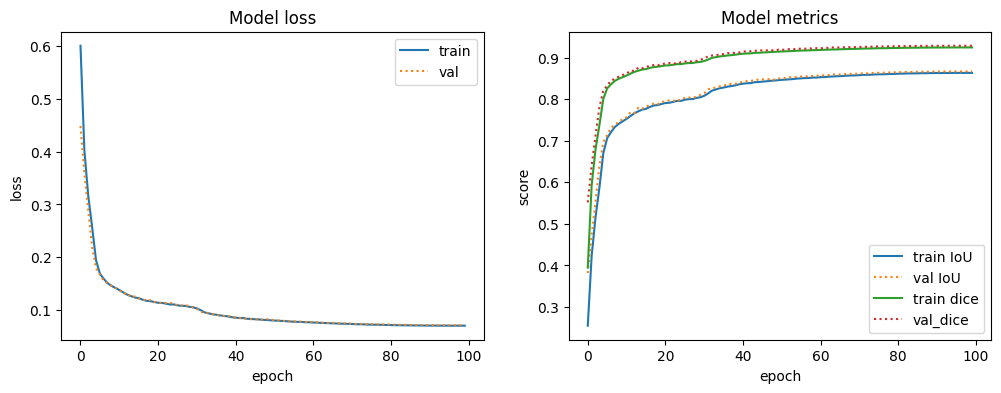

In [13]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(H['train_loss'])
plt.plot(H['test_loss'], linestyle='dotted')
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')

plt.subplot(122)
plt.plot(H['train_IoU'])
plt.plot(H['test_IoU'], linestyle='dotted')
plt.plot(H['train_DC'])
plt.plot(H['test_DC'], linestyle='dotted')
plt.title('Model metrics')
plt.ylabel('score')
plt.xlabel('epoch')

plt.legend(['train IoU', 'val IoU', 'train dice', 'val_dice'], loc='lower right')

plt.show()

In [14]:
def make_prediction(model, image):
	image = torch.Tensor(image).permute((2, 0, 1)).to(DEVICE)
	image = torch.unsqueeze(image, 0)
	# set model to evaluation mode
	model.eval()
	# turn off gradient tracking
	with torch.no_grad():
		predMask = model(image)
		predMask = softmax(predMask)
		predMask = torch.squeeze(predMask, 0)
		predMask = predMask.permute((1, 2, 0))
		predMask = predMask.cpu().detach().numpy()
		predMask = np.argmax(predMask, axis=-1)
		predMask = np.expand_dims(predMask, axis=-1)
		# filter out the weak predictions and convert them to integers
		return predMask.astype(np.uint8)


In [15]:
def getPredImg(image_path):     
    image = cv2.imread(image_path)
    image = image[10:-10, 120:-120,:]
    image = resize_with_pad(image, (INPUT_IMAGE_WIDTH, INPUT_IMAGE_HEIGHT))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = image / 255
    return image

def getPredMask(mask_path):
    mask = cv2.imread(mask_path)
    mask = mask[10:-10, 120:-120,:]
    mask = resize_with_pad(mask, (INPUT_IMAGE_WIDTH, INPUT_IMAGE_HEIGHT), (50, 50, 50))
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    mask = np.expand_dims(mask, axis=-1)
    mask = encode_mask(mask)
    return mask

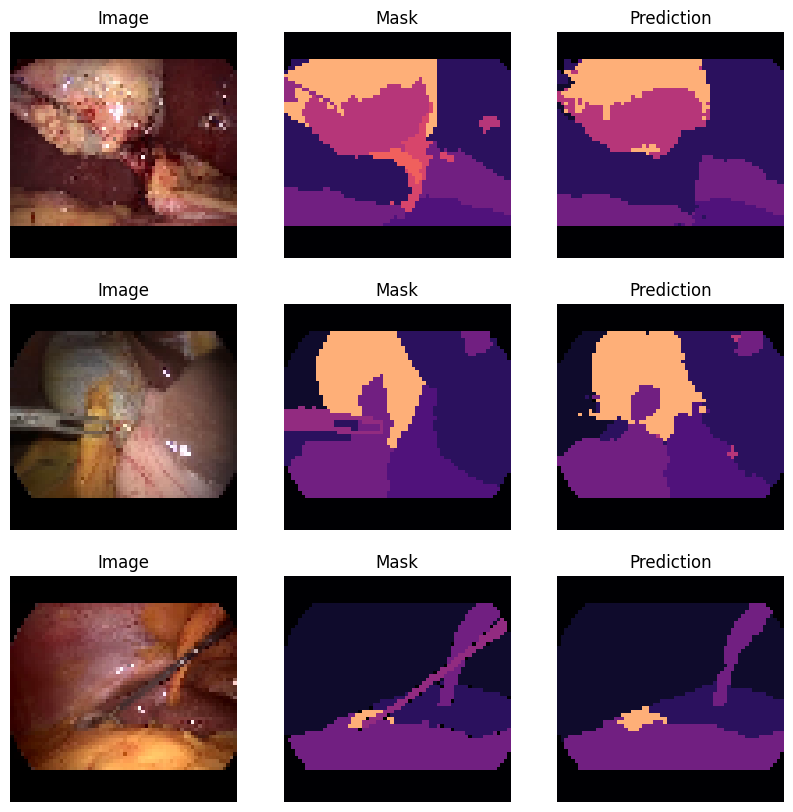

In [16]:
plt.figure(figsize=(10,10))
for i in range(3):    

    idx = random.randint(0, len(testImages) -1)
    img = getPredImg(testImages[idx])
    mask = getPredMask(testMasks[idx])
    
    plt.subplot(331 + 3*i)
    plt.imshow(img)
    plt.title('Image')
    plt.axis("off")

    mask = np.argmax(mask, axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    plt.subplot(332 + 3*i)
    plt.imshow(mask, cmap='magma', norm=plt.Normalize(vmin=0, vmax=12))
    plt.title('Mask')
    plt.axis("off")

    pred = make_prediction(uformer, img)
    plt.subplot(333 + 3*i)
    plt.imshow(pred, cmap='magma', norm=plt.Normalize(vmin=0, vmax=12))
    plt.title('Prediction')
    plt.axis("off")

plt.show()

 --- 
 TFG - Alejandro García Mota